In [5]:
import torch
from matplotlib import pyplot as plt

### MANIFOLDS

In [6]:
def corrcoef(x, y):
    
    # calculate covariance matrix of rows
    mean_x = x.mean(dim=0)
    mean_y = y.mean(dim=0)
    xm = x - mean_x
    ym = y - mean_y
    c = xm.T @ ym

    c = c / (x.size(0) - 1)
    cx = (xm ** 2).mean(dim=0).unsqueeze(-1)
    cy = (ym ** 2).mean(dim=0)
    
    

    # normalize covariance matrix
    cxx = torch.sqrt(cx)
    cyy = torch.sqrt(cy)

    c = c / cxx / cyy

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    
#     c = torch.clamp(c, -1.0, 1.0)

    return c

In [7]:
from utils.math_utils import arcosh, cosh, sinh 


class Hyperboloid():
    """
    Hyperboloid manifold class.

    We use the following convention: -x0^2 + x1^2 + ... + xd^2 = -K

    c = 1 / K is the hyperbolic curvature. 
    """

    def __init__(self):
        super(Hyperboloid, self).__init__()
        self.name = 'Hyperboloid'
        self.eps = {torch.float32: 1e-7, torch.float64: 1e-15}
        self.min_norm = 1e-15
        self.max_norm = 1e6

    def minkowski_dot(self, x, y, keepdim=True):
        #print(x.shape, y.shape)
        res = torch.sum(x * y, dim=-1) - 2 * x[..., 0] * y[..., 0]
        if keepdim:
            res = res.view(res.shape + (1,))
        return res
    
    def inner(self, p, c, x, y=None, keepdim=True):
        #print(x.shape, y.shape)
        if y == None:
            y = x
        res = torch.sum(x * y, dim=-1) - 2 * x[..., 0] * y[..., 0]
        if keepdim:
            res = res.view(res.shape + (1,))
        return res

    def minkowski_norm(self, u, keepdim=True):
        dot = self.minkowski_dot(u, u, keepdim=keepdim)
        return torch.sqrt(torch.clamp(dot, min=self.eps[u.dtype]))

    def sqdist(self, x, y, c):
        K = 1. / c
        prod = self.minkowski_dot(x, y)
        theta = torch.clamp(-prod / K, min=1.0 + self.eps[x.dtype])
        sqdist = K * arcosh(theta) ** 2
        # clamp distance to avoid nans in Fermi-Dirac decoder
#         return torch.clamp(sqdist, max=50.0)
        return sqdist

    def proj(self, x, c):
        K = 1. / c
        d = x.size(-1) - 1
        y = x.narrow(-1, 1, d)

        y_sqnorm = torch.norm(y, p=2, dim=-1, keepdim=True) ** 2 
        mask = torch.ones_like(x)
        mask[..., 0] = 0
        vals = torch.zeros_like(x)
        vals[..., 0:1] = torch.sqrt(torch.clamp(K + y_sqnorm, min=self.eps[x.dtype]))
        return vals + mask * x

    def proj_tan(self, u, x, c):
        K = 1. / c
        d = x.size(-1) - 1
        ux = torch.sum(x.narrow(-1, 1, d) * u.narrow(-1, 1, d), dim=-1, keepdim=True)
        mask = torch.ones_like(u)
        mask[..., 0] = 0
        vals = torch.zeros_like(u)
        vals[..., 0:1] = ux / torch.clamp(x[..., 0:1], min=self.eps[x.dtype])
        return vals + mask * u

    def proj_tan0(self, u, c):
        narrowed = u.narrow(-1, 0, 1)
        vals = torch.zeros_like(u)
        vals[:, 0:1] = narrowed
        return u - vals

    def expmap(self, u, x, c, verbose=False):
        if verbose:
            print(f'####### EXPMAP #######')
            print(f'Input u:\n{u}')
            print(f'Input x:\n{x}')
        
        K = 1. / c
        sqrtK = K ** 0.5
        normu = self.minkowski_norm(u)
        normu = torch.clamp(normu, max=self.max_norm)
        theta = normu / sqrtK
        theta = torch.clamp(theta, min=self.min_norm)
        result = cosh(theta) * x + sinh(theta) * u / theta

#         if verbose:      
#             print(f'theta: {torch.isnan(theta).sum().item()}, \
#                   cosh: {torch.isnan(cosh(theta)).sum().item()}, \
#                   sinh: {torch.isnan(sinh(theta)).sum().item()}')

            
        out = self.proj(result, c)
        if verbose:
            print(f'Output:\n{out}')
            print(f'$$$$$$ EXPMAP END $$$$$$')
        return out
      
    def logmap(self, x, y, c, verbose=False):
        if verbose:
            print(f'####### LOGMAP #######')
            print(f'Input x:\n{x}')
            print(f'Input y:\n{y}')
        K = 1. / c
        xy = torch.clamp(self.minkowski_dot(x, y) + K, max=-self.eps[x.dtype]) - K
        u = y + xy * x * c
        normu = self.minkowski_norm(u)
        normu = torch.clamp(normu, min=self.min_norm)
        dist = self.sqdist(x, y, c) ** 0.5
        result = dist * u / normu
            
        out = self.proj_tan(result, x, c)
        if verbose:
            print(f'Output:\n{out}')
            print(f'$$$$$$ LOGMAP END $$$$$$')
        
        return out

    def expmap0(self, u, c, verbose=False):
        if verbose:
            print(f'####### EXPMAP0 #######')
            print(f'Input:\n{u}')
        K = 1. / c
        sqrtK = K ** 0.5
        d = u.size(-1) - 1
        x = u.narrow(-1, 1, d)
        x_norm = torch.norm(x, p=2, dim=-1, keepdim=True)
        x_norm = torch.clamp(x_norm, min=self.min_norm)
        theta = x_norm / sqrtK
        res = torch.ones_like(u)
#         print(f'res shape: {res.shape} theta shape: {theta.shape}')
        res[..., 0:1] = sqrtK * cosh(theta)
        res[..., 1:] = sqrtK * sinh(theta) * x / x_norm
            
        out = self.proj(res, c)
        if verbose:
            print(f'Output:\n{out}')
            print(f'$$$$$$ EXPMAP0 END $$$$$$')

        return out

    def logmap0(self, x, c, verbose=False):
        if verbose:
            print(f'####### LOGMAP0 #######')
            print(f'Input:\n{x}')
        
        K = 1. / c
        sqrtK = K ** 0.5
        d = x.size(-1) - 1
        y = x.narrow(-1, 1, d)
        y_norm = torch.norm(y, p=2, dim=-1, keepdim=True)
        y_norm = torch.clamp(y_norm, min=self.min_norm)
        res = torch.zeros_like(x)
        theta = torch.clamp(x[..., 0:1] / sqrtK, min=1.0 + self.eps[x.dtype])
#         print(f'res: {res.shape} theta: {theta.shape}, y: {y.shape}, y_norm: {y_norm.shape}')
        res[..., 1:] = sqrtK * arcosh(theta) * y / y_norm
        if verbose:           
            print(f'Output:\n{res}')
            print(f'$$$$$$ LOGMAP0 END $$$$$$')
        
        
        return res

    def mobius_add(self, x, y, c):
        u = self.logmap0(y, c)
        v = self.ptransp0(x, u, c)
        return self.expmap(v, x, c)
    
    def poincare_mobius_add(self, x, y, c, dim=-1):
        x2 = x.pow(2).sum(dim=dim, keepdim=True)
        y2 = y.pow(2).sum(dim=dim, keepdim=True)
        xy = (x * y).sum(dim=dim, keepdim=True)
        num = (1 + 2 * c * xy + c * y2) * x + (1 - c * x2) * y
        denom = 1 + 2 * c * xy + c ** 2 * x2 * y2
        return num / denom.clamp_min(self.min_norm)
    
    def poincare_mobius_coadd(self, x, y, c, dim=-1):
        x2 = x.pow(2).sum(dim=dim, keepdim=True)
        y2 = y.pow(2).sum(dim=dim, keepdim=True)
        num = (1 + c * y2) * x + (1 + c * x2) * y
        denom = 1 - c ** 2 * x2 * y2
        return num / denom.clamp_min(self.min_norm)
    

    def mobius_matvec(self, m, x, c, verbose=False):   
        if verbose:
            print(f'################ MOBIUS MATVEC #################')
            print(f'Input:\n{x}')
        u = self.logmap0(x, c)
        if verbose:
            print(f'u=logmap0(x): {u}')
        
        mu = u @ m.transpose(-1, -2)
        if verbose:
            print(f'm@u:\n{mu}')
        out = self.expmap0(mu, c)
        if verbose:
            print(f'out=expmap0(mu):\n{out}')
            print(f'$$$$$$$$$$$$$$$$ MOBIUS MATVEC END $$$$$$$$$$$$$$$$$$')
        return out

    def ptransp(self, x, y, u, c):
        logxy = self.logmap(x, y, c)
        logyx = self.logmap(y, x, c)
        sqdist = torch.clamp(self.sqdist(x, y, c), min=self.min_norm)
        alpha = self.minkowski_dot(logxy, u) / sqdist
        res = u - alpha * (logxy + logyx)
        return self.proj_tan(res, y, c)

    def ptransp0(self, x, u, c):
        K = 1. / c
        sqrtK = K ** 0.5
        x0 = x.narrow(-1, 0, 1)
        d = x.size(-1) - 1
        y = x.narrow(-1, 1, d)
        y_norm = torch.clamp(torch.norm(y, p=2, dim=-1, keepdim=True), min=self.min_norm)
        y_normalized = y / y_norm
        v = torch.ones_like(x)
        v[..., 0:1] = - y_norm 
        v[..., 1:] = (sqrtK - x0) * y_normalized
        alpha = torch.sum(y_normalized * u[..., 1:], dim=-1, keepdim=True) / sqrtK
        res = u - alpha * v
        return self.proj_tan(res, x, c)

    def to_poincare(self, x, c, verbose=False):
        if verbose:
            print(f'####### TO POINCARE #######')
            print(f'Input:\n{x}')
        K = 1. / c
        sqrtK = K ** 0.5
        d = x.size(-1) - 1
        out = sqrtK * x.narrow(-1, 1, d) / (x[..., 0:1] + sqrtK)
        if verbose:
            print(f'Output:\n{out}')
            print(f'$$$$$$$ TO POINCARE END $$$$$$$')
        return out

    def to_hyperboloid(self, x, c, verbose=False):
        if verbose:
            print(f'####### TO HYPERBOLOID #######')
            print(f'Input:\n{x}')
        K = 1./ c
        sqrtK = K ** 0.5
        sqnorm = torch.norm(x, p=2, dim=-1, keepdim=True) ** 2
        out = sqrtK * torch.cat([K + sqnorm, 2 * sqrtK * x], dim=-1) / (K - sqnorm)
        
        if verbose:
            print(f'Output:\n{out}')
            print(f'$$$$$$$ TO HYPERBOLOID END $$$$$$$')
        
        return out

    def egrad2rgrad(self, p, dp, c):
        K = 1. / c
        sqrtK = K ** 0.5
        u = dp
        x = p
        u.narrow(-1, 0, 1).mul_(-1 / sqrtK)
        u.addcmul_(self.minkowski_dot(x, u, keepdim=True).expand_as(x), x)
        
        return u

### LAYERS

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.modules.module import Module

from torch_scatter import gather_csr, scatter, segment_csr
from torch_geometric.nn import MessagePassing

class MyHyperbolicGraphConvolution(MessagePassing):
    def __init__(self, manifold, in_channels, out_channels, c, dropout=0, use_att=False, use_bias=False, verbose=False, aggr='add'):
        super().__init__(aggr=aggr)
#         print(f'in: {in_channels}, out: {out_channels}, c: {c}, dropout: {dropout}, att: {use_att}, bias: {use_bias}')
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels))
        self.bias = nn.Parameter(torch.Tensor(out_channels)) if use_bias else None
        self.att = nn.Linear(2 * out_channels, 1) if use_att else None
        self.dropout = nn.Dropout(p=dropout)
        self.manifold = manifold
        self.c = c
        self.verbose = verbose
        self.reset_parameters()
    
    def set_verbose(self, verbose):
        self.verbose = verbose
        
    def reset_parameters(self):
        init.xavier_uniform_(self.weight, gain=1)
        if self.bias is not None:
            init.constant_(self.bias, 0)
    
    def message(self, x_j, x_i):
        out = self.manifold.logmap(x_j, x_i, self.c, self.verbose)
        
        return out
    
    def aggregate(self, inputs, x_i, x_j, index, ptr=None, dim_size=None):
        if ptr is not None:
            ptr = expand_left(ptr, dim=self.node_dim, dims=inputs.dim())
            return segment_csr(inputs, ptr, reduce=self.aggr)
        else:
            if self.verbose:
                print('--------------------AGGREGATE--------------------------')
                print(f'inputs: {inputs.shape} x_i shape: {x_i.shape}, x_j shape: {x_j.shape}')
            if self.att is not None:
                x_i0 = self.manifold.logmap0(x_i, c=self.c)
                x_j0 = self.manifold.logmap0(x_j, c=self.c)
                att_scores = self.att(torch.cat([x_i0, x_j0], dim=-1))
                att_scores = torch.sigmoid(att_scores).reshape(-1, 1)
                out = inputs * att_scores
            else:
                out = inputs
            if self.verbose:
                print('++++++++++++++++++++AGGREGATE++++++++++++++++++++++++++')
                
            return scatter(out, index, dim=self.node_dim, dim_size=dim_size,
                           reduce=self.aggr)
        
    def update(self, inputs, x):
        if self.verbose:
            print('----------------------UPDATE-------------------------')
            print(f'inputs shape: {inputs.shape}, x shape: {x.shape}')

        out = self.manifold.expmap(inputs, x, self.c, self.verbose)
        out = self.manifold.proj(out, c=self.c)

        out = self.manifold.to_poincare(out, self.c, self.verbose)
        out = F.relu(out)
        out = self.manifold.to_hyperboloid(out, self.c, self.verbose)
        out = self.manifold.proj(out, c=self.c)
        if self.verbose:
            print('++++++++++++++++++++++UPDATE++++++++++++++++++++++++++')
                        
        return out
        
    def forward(self, x, edge_index):
        drop_weight = self.dropout(self.weight)
        x = self.manifold.mobius_matvec(drop_weight, x, self.c, self.verbose)
        x = self.manifold.proj(x, c=self.c)
        if self.bias is not None:
            hyp_bias = self.manifold.expmap0(self.bias.view(1, -1), self.c)
            hyp_bias = self.manifold.proj(hyp_bias, c=self.c)
            x = self.manifold.mobius_add(x, hyp_bias, self.c)
            x = self.manifold.proj(x, c=self.c)
            
        return self.propagate(edge_index, x=x)
    

class HypLinear(nn.Module):
    """
    Hyperbolic linear layer.
    """

    def __init__(self, manifold, in_features, out_features, c, dropout, use_bias):
        super(HypLinear, self).__init__()
        self.manifold = manifold
        self.in_features = in_features
        self.out_features = out_features
        self.c = c
        self.dropout = dropout
        self.use_bias = use_bias
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.verbose = False
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(123)
        init.xavier_uniform_(self.weight, gain=math.sqrt(1))
        init.constant_(self.bias, 0)
        
    def set_verbose(self, verbose=True):
        self.verbose=verbose

    def forward(self, x):
        drop_weight = F.dropout(self.weight, self.dropout, training=self.training)
        mv = self.manifold.mobius_matvec(drop_weight, x, self.c, verbose=self.verbose)
        res = self.manifold.proj(mv, self.c)
        if self.use_bias:
            bias = self.manifold.proj_tan0(self.bias.view(1, -1), self.c)
            hyp_bias = self.manifold.expmap0(bias, self.c)
            hyp_bias = self.manifold.proj(hyp_bias, self.c)
            res = self.manifold.mobius_add(res, hyp_bias, c=self.c)
            res = self.manifold.proj(res, self.c)
        return res

    def extra_repr(self):
        return 'in_features={}, out_features={}, c={}'.format(
            self.in_features, self.out_features, self.c
        )

### MODELS

In [9]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import Parameter, Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d as BN
from torch.nn import init

from torch_scatter import scatter_add
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn.inits import reset

from scipy.special import beta

from manifolds.hyperboloid import Hyperboloid
from layers.hyp_layers import MyHyperbolicGraphConvolution, HypLinear, HypReLU
from layers.rel import RelConv

import math
from utils.math_utils import arcosh, cosh, sinh 



try:
    from pykeops.torch import LazyTensor
except ImportError:
    LazyTensor = None

    
class HyperbolicRelCNN(torch.nn.Module):
    def __init__(self, manifold, in_channels, out_channels, c, num_layers,
                 cat=True, lin=True, dropout=0.0, use_att=False, use_bias=True):
        super(HyperbolicRelCNN, self).__init__()
        
        self.in_channels = in_channels
        self.num_layers = num_layers
        self.cat = cat
        self.lin = lin
        self.dropout = dropout
        self.manifold = manifold
        self.c = c
        
        self.convs = torch.nn.ModuleList()

        for _ in range(self.num_layers):
            self.convs.append(MyHyperbolicGraphConvolution(manifold, in_channels, out_channels, c, dropout=dropout, use_att=use_att, use_bias=use_bias))
            in_channels = out_channels

        if self.cat:
            in_channels = self.in_channels + num_layers * out_channels
        else:
            in_channels = out_channels

        if self.lin:
            self.out_channels = out_channels
            self.final = HypLinear(manifold, in_channels, out_channels, c, dropout, use_bias)
        else:
            self.out_channels = in_channels
        
        total_channels = self.in_channels + self.num_layers * self.out_channels
        
        self.beta_in = beta(self.in_channels/2., 1./self.in_channels)
        self.beta_out = beta(self.out_channels/2., 1./self.out_channels)
        self.beta_total = beta(total_channels/2., 1./total_channels)

        self.reset_parameters()
    
    @property
    def device(self):
        return self.convs[0].weight.device
    
    def set_verbose(self, verbose=True):
        for conv in self.convs:
            conv.set_verbose(verbose)
    
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.lin:
            self.final.reset_parameters()

    def forward(self, x, edge_index, edge_attr):
        
        xs = [x]
        for conv in self.convs:
            x = conv(xs[-1], edge_index)
            xs.append(x)
                        
        if self.cat:
            xs[0] = self.manifold.logmap0(xs[0], c=self.c) * self.beta_total / self.beta_in
            
            for x in xs[1:]:
                x = self.manifold.logmap0(x, c=self.c) * self.beta_total / self.beta_out    
            x = torch.cat(xs, dim=-1)
            x = self.manifold.expmap0(x, c=self.c)
        else:
            x = xs[-1]
            
        x = self.final(x) if self.lin else x
        
        return x

    def __repr__(self):
        return ('{}({}, {}, num_layers={}, cat={}, lin={}, '
                'dropout={})').format(self.__class__.__name__,
                                      self.in_channels, self.out_channels,
                                      self.num_layers,
                                      self.cat, self.lin, self.dropout)



EPS = 1e-8


def masked_softmax(src, mask, dim=-1):
    out = src.masked_fill(~mask, float('-inf'))
    out = torch.softmax(out, dim=dim)
    out = out.masked_fill(~mask, 0)
    return out


def to_sparse(x, mask):
    return x[mask]


def to_dense(x, mask):
    out = x.new_zeros(tuple(mask.size()) + (x.size(-1), ))
    out[mask] = x
    return out


class HyperbolicGraphMatching(torch.nn.Module):
    def __init__(self, input_dim, psi, k=-1, sim='mindot'):
        super().__init__()
        assert sim in ['mindot', 'sqdist']
        self.psi = psi
        self.k = k
        self.backend = 'auto'
        self.manifold = psi.manifold
        self.c = psi.c
        self.sim = sim
        self.lin = Lin(input_dim, psi.in_channels, bias=False)
        torch.nn.init.xavier_uniform_(self.lin.weight, gain=0.2)
        
    def reset_parameters(self):
        self.psi_1.reset_parameters()
        reset(self.mlp)

    def __top_k__(self, x_s, x_t):  # pragma: no cover
        S_ij = (x_s @ x_t.transpose(-1, -2)) - 2 * torch.einsum('bi,bj->bij', (x_s[..., :, 0], x_t[..., :, 0]))
        
        if self.sim == 'sqdist':
            K = 1. / self.c
            theta = torch.clamp(-S_ij / K, min=1.0 + 1e-15)
            S_ij = -K * arcosh(theta) ** 2
        
        return S_ij.topk(self.k, dim=2)[1]

    def __include_gt__(self, S_idx, s_mask, y):
        r"""Includes the ground-truth values in :obj:`y` to the index tensor
        :obj:`S_idx`."""
        (B, N_s), (row, col), k = s_mask.size(), y, S_idx.size(-1)

        gt_mask = (S_idx[s_mask][row] != col.view(-1, 1)).all(dim=-1)

        sparse_mask = gt_mask.new_zeros((s_mask.sum(), ))
        sparse_mask[row] = gt_mask

        dense_mask = sparse_mask.new_zeros((B, N_s))
        dense_mask[s_mask] = sparse_mask
        last_entry = torch.zeros(k, dtype=torch.bool, device=gt_mask.device)
        last_entry[-1] = 1
        dense_mask = dense_mask.view(B, N_s, 1) * last_entry.view(1, 1, k)

        return S_idx.masked_scatter(dense_mask, col[gt_mask])

    def forward(self, x_s, edge_index_s, edge_attr_s, batch_s, x_t,
                edge_index_t, edge_attr_t, batch_t, y=None):
        
        x_s = self.lin(x_s)
        x_t = self.lin(x_t)
        x_s = self.manifold.expmap0(x_s, c=self.c)
        x_t = self.manifold.expmap0(x_t, c=self.c)
        x_s = self.manifold.proj(x_s, c=self.c)
        x_t = self.manifold.proj(x_t, c=self.c)
        
        h_s = self.psi(x_s, edge_index_s, edge_attr_s)
        h_t = self.psi(x_t, edge_index_t, edge_attr_t)
        

        h_s, s_mask = to_dense_batch(h_s, batch_s, fill_value=0)
        h_t, t_mask = to_dense_batch(h_t, batch_t, fill_value=0)
        
        
        assert h_s.size(0) == h_t.size(0), 'Encountered unequal batch-sizes'
        (B, N_s, C_out), N_t = h_s.size(), h_t.size(1)
        
        if self.k < 1:
            # ------ Dense variant ------ #
            S_hat = (h_s @ h_t.transpose(-1, -2)) - 2 * torch.einsum('bi,bj->bij', (h_s[..., :, 0], h_t[..., :, 0]))
            if self.sim == 'sqdist':
                K = 1. / self.c
                theta = torch.clamp(-S_hat / K, min=1.0 + 1e-15)
                S_hat = -K * arcosh(theta) ** 2
                
            S_mask = s_mask.view(B, N_s, 1) & t_mask.view(B, 1, N_t)
            S_0 = masked_softmax(S_hat, S_mask, dim=-1)[s_mask]

            return S_0
        
        else:
            # ------ Sparse variant ------ #
            S_idx = self.__top_k__(h_s, h_t)  # [B, N_s, k]

            # In addition to the top-k, randomly sample negative examples and
            # ensure that the ground-truth is included as a sparse entry.
            if self.training and y is not None:
                rnd_size = (B, N_s, min(self.k, N_t - self.k))
                S_rnd_idx = torch.randint(N_t, rnd_size, dtype=torch.long,
                                          device=S_idx.device)
                S_idx = torch.cat([S_idx, S_rnd_idx], dim=-1)
                S_idx = self.__include_gt__(S_idx, s_mask, y)

            k = S_idx.size(-1)
            tmp_s = h_s.view(B, N_s, 1, C_out)
            idx = S_idx.view(B, N_s * k, 1).expand(-1, -1, C_out)
            tmp_t = torch.gather(h_t.view(B, N_t, C_out), -2, idx)
            S_hat = (tmp_s * tmp_t.view(B, N_s, k, C_out)).sum(dim=-1) - 2 * (tmp_s[..., 0] * tmp_t.view(B, N_s, k, C_out)[..., 0])

            if self.sim == 'sqdist':
                K = 1. / self.c
                theta = torch.clamp(-S_hat / K, min=1.0 + 1e-15)
                S_hat = -K * arcosh(theta) ** 2

            S_0 = S_hat.softmax(dim=-1)[s_mask]

            S_idx = S_idx[s_mask]

            # Convert sparse layout to `torch.sparse_coo_tensor`.
            row = torch.arange(x_s.size(0), device=S_idx.device)
            row = row.view(-1, 1).repeat(1, k)
            idx = torch.stack([row.view(-1), S_idx.view(-1)], dim=0)
            size = torch.Size([x_s.size(0), N_t])

            S_sparse_0 = torch.sparse_coo_tensor(
                idx, S_0.view(-1), size, requires_grad=S_0.requires_grad)
            S_sparse_0.__idx__ = S_idx
            S_sparse_0.__val__ = S_0


            return S_sparse_0

    def loss(self, S, y, reduction='mean'):
        r"""Computes the negative log-likelihood loss on the correspondence
        matrix.

        Args:
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'none'|'mean'|'sum'`.
                (default: :obj:`'mean'`)
        """
        assert reduction in ['none', 'mean', 'sum']
        if not S.is_sparse:
            val = S[y[0], y[1]]
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            mask = S.__idx__[y[0]] == y[1].view(-1, 1)
            val = S.__val__[[y[0]]][mask]
            
        nll = -torch.log(val + EPS)

        return nll if reduction == 'none' else getattr(torch, reduction)(nll)

    def acc(self, S, y, reduction='mean'):
        r"""Computes the accuracy of correspondence predictions.

        Args:
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'mean'|'sum'`. (default: :obj:`'mean'`)
        """
        assert reduction in ['mean', 'sum']
        if not S.is_sparse:
            pred = S[y[0]].argmax(dim=-1)
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            pred = S.__idx__[y[0], S.__val__[y[0]].argmax(dim=-1)]

        correct = (pred == y[1]).sum().item()
        return correct / y.size(1) if reduction == 'mean' else correct

    def hits_at_k(self, k, S, y, reduction='mean'):
        r"""Computes the hits@k of correspondence predictions.

        Args:
            k (int): The :math:`\mathrm{top}_k` predictions to consider.
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'mean'|'sum'`. (default: :obj:`'mean'`)
        """
        assert reduction in ['mean', 'sum']
        if not S.is_sparse:
            pred = S[y[0]].argsort(dim=-1, descending=True)[:, :k]
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            perm = S.__val__[y[0]].argsort(dim=-1, descending=True)[:, :k]
            pred = torch.gather(S.__idx__[y[0]], -1, perm)

        correct = (pred == y[1].view(-1, 1)).sum().item()
        return correct / y.size(1) if reduction == 'mean' else correct

    def __repr__(self):
        return ('{}(\n'
                '    psi_1={},\n'
                '    k={}\n)').format(self.__class__.__name__,
                                                    self.psi_1,
                                                    self.k)

    
class EuclideanGraphMatching(torch.nn.Module):
    def __init__(self, psi, k=-1):
        super().__init__()

        self.psi = psi
        self.k = k
        self.backend = 'auto'

    def reset_parameters(self):
        self.psi.reset_parameters()
        reset(self.mlp)

    def __top_k__(self, x_s, x_t):  # pragma: no cover
        r"""Memory-efficient top-k correspondence computation."""
        x_s = x_s  # [..., n_s, d]
        x_t = x_t.transpose(-1, -2)  # [..., d, n_t]
        S_ij = x_s @ x_t
        return S_ij.topk(self.k, dim=2)[1]

    def __include_gt__(self, S_idx, s_mask, y):
        r"""Includes the ground-truth values in :obj:`y` to the index tensor
        :obj:`S_idx`."""
        (B, N_s), (row, col), k = s_mask.size(), y, S_idx.size(-1)

        gt_mask = (S_idx[s_mask][row] != col.view(-1, 1)).all(dim=-1)

        sparse_mask = gt_mask.new_zeros((s_mask.sum(), ))
        sparse_mask[row] = gt_mask

        dense_mask = sparse_mask.new_zeros((B, N_s))
        dense_mask[s_mask] = sparse_mask
        last_entry = torch.zeros(k, dtype=torch.bool, device=gt_mask.device)
        last_entry[-1] = 1
        dense_mask = dense_mask.view(B, N_s, 1) * last_entry.view(1, 1, k)

        return S_idx.masked_scatter(dense_mask, col[gt_mask])

    def forward(self, x_s, edge_index_s, edge_attr_s, batch_s, x_t,
                edge_index_t, edge_attr_t, batch_t, y=None):
        r"""
        Args:
            x_s (Tensor): Source graph node features of shape
                :obj:`[batch_size * num_nodes, C_in]`.
            edge_index_s (LongTensor): Source graph edge connectivity of shape
                :obj:`[2, num_edges]`.
            edge_attr_s (Tensor): Source graph edge features of shape
                :obj:`[num_edges, D]`. Set to :obj:`None` if the GNNs are not
                taking edge features into account.
            batch_s (LongTensor): Source graph batch vector of shape
                :obj:`[batch_size * num_nodes]` indicating node to graph
                assignment. Set to :obj:`None` if operating on single graphs.
            x_t (Tensor): Target graph node features of shape
                :obj:`[batch_size * num_nodes, C_in]`.
            edge_index_t (LongTensor): Target graph edge connectivity of shape
                :obj:`[2, num_edges]`.
            edge_attr_t (Tensor): Target graph edge features of shape
                :obj:`[num_edges, D]`. Set to :obj:`None` if the GNNs are not
                taking edge features into account.
            batch_s (LongTensor): Target graph batch vector of shape
                :obj:`[batch_size * num_nodes]` indicating node to graph
                assignment. Set to :obj:`None` if operating on single graphs.
            y (LongTensor, optional): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]` to include ground-truth values
                when training against sparse correspondences. Ground-truths
                are only used in case the model is in training mode.
                (default: :obj:`None`)

        Returns:
            Initial and refined correspondence matrices :obj:`(S_0, S_L)`
            of shapes :obj:`[batch_size * num_nodes, num_nodes]`. The
            correspondence matrix are either given as dense or sparse matrices.
        """
        h_s = self.psi(x_s, edge_index_s, edge_attr_s)
        h_t = self.psi(x_t, edge_index_t, edge_attr_t)

        h_s, s_mask = to_dense_batch(h_s, batch_s, fill_value=0)
        h_t, t_mask = to_dense_batch(h_t, batch_t, fill_value=0)

        assert h_s.size(0) == h_t.size(0), 'Encountered unequal batch-sizes'
        (B, N_s, C_out), N_t = h_s.size(), h_t.size(1)

        if self.k < 1:
            # ------ Dense variant ------ #
            S_hat = h_s @ h_t.transpose(-1, -2)  # [B, N_s, N_t, C_out]
            S_mask = s_mask.view(B, N_s, 1) & t_mask.view(B, 1, N_t)
            S_0 = masked_softmax(S_hat, S_mask, dim=-1)[s_mask]

            return S_0
        else:
            # ------ Sparse variant ------ #
            S_idx = self.__top_k__(h_s, h_t)  # [B, N_s, k]

            # In addition to the top-k, randomly sample negative examples and
            # ensure that the ground-truth is included as a sparse entry.
            if self.training and y is not None:
                rnd_size = (B, N_s, min(self.k, N_t - self.k))
                S_rnd_idx = torch.randint(N_t, rnd_size, dtype=torch.long,
                                          device=S_idx.device)
                S_idx = torch.cat([S_idx, S_rnd_idx], dim=-1)
                S_idx = self.__include_gt__(S_idx, s_mask, y)

            k = S_idx.size(-1)
            tmp_s = h_s.view(B, N_s, 1, C_out)
            idx = S_idx.view(B, N_s * k, 1).expand(-1, -1, C_out)
            tmp_t = torch.gather(h_t.view(B, N_t, C_out), -2, idx)
            S_hat = (tmp_s * tmp_t.view(B, N_s, k, C_out)).sum(dim=-1)
            S_0 = S_hat.softmax(dim=-1)[s_mask]

            S_idx = S_idx[s_mask]

            # Convert sparse layout to `torch.sparse_coo_tensor`.
            row = torch.arange(x_s.size(0), device=S_idx.device)
            row = row.view(-1, 1).repeat(1, k)
            idx = torch.stack([row.view(-1), S_idx.view(-1)], dim=0)
            size = torch.Size([x_s.size(0), N_t])

            S_sparse_0 = torch.sparse_coo_tensor(
                idx, S_0.view(-1), size, requires_grad=S_0.requires_grad)
            S_sparse_0.__idx__ = S_idx
            S_sparse_0.__val__ = S_0

            return S_sparse_0

    def loss(self, S, y, reduction='mean'):
        r"""Computes the negative log-likelihood loss on the correspondence
        matrix.

        Args:
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'none'|'mean'|'sum'`.
                (default: :obj:`'mean'`)
        """
        assert reduction in ['none', 'mean', 'sum']
        if not S.is_sparse:
            val = S[y[0], y[1]]
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            mask = S.__idx__[y[0]] == y[1].view(-1, 1)
            val = S.__val__[[y[0]]][mask]
        nll = -torch.log(val + EPS)
        return nll if reduction == 'none' else getattr(torch, reduction)(nll)

    def acc(self, S, y, reduction='mean'):
        r"""Computes the accuracy of correspondence predictions.

        Args:
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'mean'|'sum'`. (default: :obj:`'mean'`)
        """
        assert reduction in ['mean', 'sum']
        if not S.is_sparse:
            pred = S[y[0]].argmax(dim=-1)
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            pred = S.__idx__[y[0], S.__val__[y[0]].argmax(dim=-1)]

        correct = (pred == y[1]).sum().item()
        return correct / y.size(1) if reduction == 'mean' else correct

    def hits_at_k(self, k, S, y, reduction='mean'):
        r"""Computes the hits@k of correspondence predictions.

        Args:
            k (int): The :math:`\mathrm{top}_k` predictions to consider.
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'mean'|'sum'`. (default: :obj:`'mean'`)
        """
        assert reduction in ['mean', 'sum']
        if not S.is_sparse:
            pred = S[y[0]].argsort(dim=-1, descending=True)[:, :k]
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            perm = S.__val__[y[0]].argsort(dim=-1, descending=True)[:, :k]
            pred = torch.gather(S.__idx__[y[0]], -1, perm)

        correct = (pred == y[1].view(-1, 1)).sum().item()
        return correct / y.size(1) if reduction == 'mean' else correct

    def __repr__(self):
        return ('{}(\n'
                '    psi={},\n'
                '    k={}\n)').format(self.__class__.__name__,
                                                    self.psi,
                                                    self.k)


In [15]:
def train():
    model.train()
    optimizer.zero_grad()
    S_L = model(x1, edge_index1, None, None, x2,
                   edge_index2, None, None, y=train_y)
    
    loss = model.loss(S_L, train_y)
    hits1 = model.acc(S_L, train_y)
    hits10 = model.hits_at_k(10, S_L, train_y)
    
    loss.backward()
    optimizer.step()
    

    return loss, hits1, hits10


@torch.no_grad()
def test():
    model.eval()

    S_L = model(x1, edge_index1, None, None, x2,
                   edge_index2, None, None)
    
    loss = model.loss(S_L, test_y)
    hits1 = model.acc(S_L, test_y)
    hits10 = model.hits_at_k(10, S_L, test_y)

    return loss, hits1, hits10

In [16]:
import numpy as np
from dgmc.models import DGMC, RelCNN
from torch_geometric.utils import add_self_loops

from networkx.generators.trees import random_tree
from networkx.generators.random_graphs import erdos_renyi_graph

def get_dataset(dataset_name, num_nodes, input_dim, num_edges,
                p_erdos_renyi, train_size, be_hyperbolic, c=1, noise=0.1):
    
    ind = np.arange(num_nodes)
    perm = np.random.permutation(ind)
    noise = noise / (input_dim)
    x1 = torch.randn(num_nodes, input_dim) / (input_dim)
    x2 = (x1 + noise * torch.randn(num_nodes, input_dim))[perm]

    if be_hyperbolic:
        hyp = Hyperboloid()

        x1 = hyp.proj_tan0(x1, c=c)
        x1 = hyp.expmap0(x1, c=c)
        x1 = hyp.proj(x1, c=c)
        
        x2 = hyp.proj_tan0(x2, c=c)
        x2 = hyp.expmap0(x2, c=c)
        x2 = hyp.proj(x2, c=c)
    
    if dataset_name == 1:
        p_s = torch.tensor(np.random.uniform(low=0.1, high=1, size=num_nodes))
        p_t = torch.tensor(np.random.uniform(low=0.1, high=1, size=num_nodes))

        p_s = torch.softmax(p_s, dim=-1)
        p_t = torch.softmax(p_t, dim=-1)

        n_s = np.random.choice(ind, size=num_edges, p=p_s)
        n_t = np.random.choice(ind, size=num_edges, p=p_t)

        edge_index1 = torch.tensor([n_s, n_t]).long()
        
    elif dataset_name == 2:
        edge_index1 = torch.tensor(list(random_tree(num_nodes).edges)).T.long()
        
    elif dataset_name == 3:
        edge_index1 = torch.tensor(list(erdos_renyi_graph(num_nodes, p_erdos_renyi).edges)).T.long()
        
    else:
        raise ValueError('wrong dataset name!')
        
    edge_index1 = add_self_loops(edge_index1)[0]
    
    edge_index2 = torch.tensor(list(map(lambda x: perm[x], edge_index1))).long()

    gt = torch.tensor([perm, ind]).long()

    train_y, test_y = gt[..., :train_size], gt[..., train_size:]

    x1, edge_index1, x2, edge_index2, train_y, test_y = \
    x1.to(device), edge_index1.to(device), x2.to(device), \
    edge_index2.to(device), train_y.to(device), test_y.to(device)
    
    return x1, edge_index1, x2, edge_index2, train_y, test_y, perm


def get_model(be_hyperbolic, input_dim, dim_1, dim_2, num_layers, cat, k, c=1,
              lin=True, dropout=0.0, use_bias=True, use_att=False, aggr='mean', hyp_mlp=True):
    if be_hyperbolic:
        psi_1 = HyperbolicRelCNN(Hyperboloid(), input_dim, dim_1, c, num_layers, 
                       cat=cat, lin=lin, dropout=dropout, use_bias=use_bias, use_att=use_att)

        model = HyperbolicGraphMatching(input_dim, psi_1, k=k).to(device)
    else:
        psi_1 = RelCNN(input_dim, dim_1, num_layers, batch_norm=False,
                   cat=True, lin=True, dropout=0.0)

        model = EuclideanGraphMatching(psi_1, k=k).to(device)

    return model

def get_dataset_name(val):
    if val == 1:
        name = 'basic'
    elif val == 2:
        name = 'tree'
    elif val == 3:
        name ='erdos_renyi'
    else:
        raise ValueError('wrong dataset name!')

    return name

def get_model_name(be_hyperbolic):
    if be_hyperbolic:
        name = 'HDGMC'
    else:
        name = 'DGMC'
    
    return name

def plot_results(loss_history_train, hits1_history_train, hits10_history_train,
                loss_history_test, hits1_history_test, hits10_history_test):
    print(picname)
    plt.figure(figsize=(20,20))
    plt.subplot(2, 2, 1)
    plt.plot(loss_history_train, label='train')
    plt.plot(loss_history_test, label='test')
    plt.title('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.ylim(bottom=0)

    plt.subplot(2, 2, 2)
    plt.plot(hits1_history_train, label='train')
    plt.plot(hits1_history_test, label='test')
    plt.title('hits1')
    plt.xlabel('epoch')
    plt.legend()
    plt.ylim(0, 1)

    plt.subplot(2, 2, 3)
    plt.plot(hits10_history_train, label='train')
    plt.plot(hits10_history_test, label='test')
    plt.title('hits10')
    plt.xlabel('epoch')
    plt.legend()
    plt.ylim(0, 1)

    plt.savefig(picname)
    plt.show()

    
def run_exp(stage_2=True):
    
    
    num_nodes = 500
    num_edges = 10 * num_nodes
    p_erdos_renyi = 0.1
    input_dim = 50
    train_size = num_nodes // 2
    dim_1 = 25
    dim_2 = 10
    num_layers = 2
    cat = 'hyp1'
    k = 500
    c = 1
    device = 'cuda'
    num_steps = 50
    be_hyperbolic = True
    dataset = 3
    lr = 3e-3
    hyp_mlp = True
    aggr = 'add'

    dname = get_dataset_name(dataset)
    mname = get_model_name(be_hyperbolic)
    picname = f'{mname}_{dname}.jpg'
    
    
    x1, edge_index1, x2, edge_index2, train_y, test_y, perm = \
        get_dataset(dataset, num_nodes, input_dim, num_edges,
                p_erdos_renyi, train_size, be_hyperbolic, c=c, noise=0.1)

    model = get_model(be_hyperbolic, input_dim, dim_1, dim_2, num_layers, cat, k, c=c, aggr=aggr, hyp_mlp=hyp_mlp)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history_train, hits1_history_train, hits10_history_train = [], [], []
    loss_history_test, hits1_history_test, hits10_history_test = [], [], []

    print('Optimize initial feature matching...\n')
    model.num_steps = 0
    for epoch in range(50):
        print(f'{epoch} ', end='\r')
        if epoch == 25 and stage_2:
            print('\nRefine correspondence matrix...\n')
            model.psi_2.requires_grad_(False)
            model.num_steps = num_steps
            for g in optimizer.param_groups:
                g['lr'] = lr / 30




        loss, hits1, hits10 = train()

        loss_history_train.append(loss)
        hits1_history_train.append(hits1)
        hits10_history_train.append(hits10)

        loss, hits1, hits10 = test()
        if torch.isnan(loss).item():
            print('NUN LOSS DETECTED')
            break

        loss_history_test.append(loss)
        hits1_history_test.append(hits1)
        hits10_history_test.append(hits10)

    plot_results(loss_history_train, hits1_history_train, hits10_history_train,
                loss_history_test, hits1_history_test, hits10_history_test)

### DEFINING DATA AND HYPERPARAMETERS

In [17]:
num_nodes = 500
num_edges = 10 * num_nodes
p_erdos_renyi = 0.2
input_dim = 50
train_size = num_nodes // 2
dim_1 = 25
dim_2 = 10
num_layers = 2
cat = 'hyp1'
k = 10
c = 1
device = 'cuda'
num_steps = 10
be_hyperbolic = True
dataset = 3
lr = 3e-3
hyp_mlp = False
aggr = 'add'

dname = get_dataset_name(dataset)
mname = get_model_name(be_hyperbolic)
picname = f'{mname}_{dname}.jpg'

### TRAINING RUN AND PLOTTING

### PLAYGROUND

Optimize initial feature matching...

25 
Refine correspondence matrix...

HDGMC_erdos_renyi.jpg


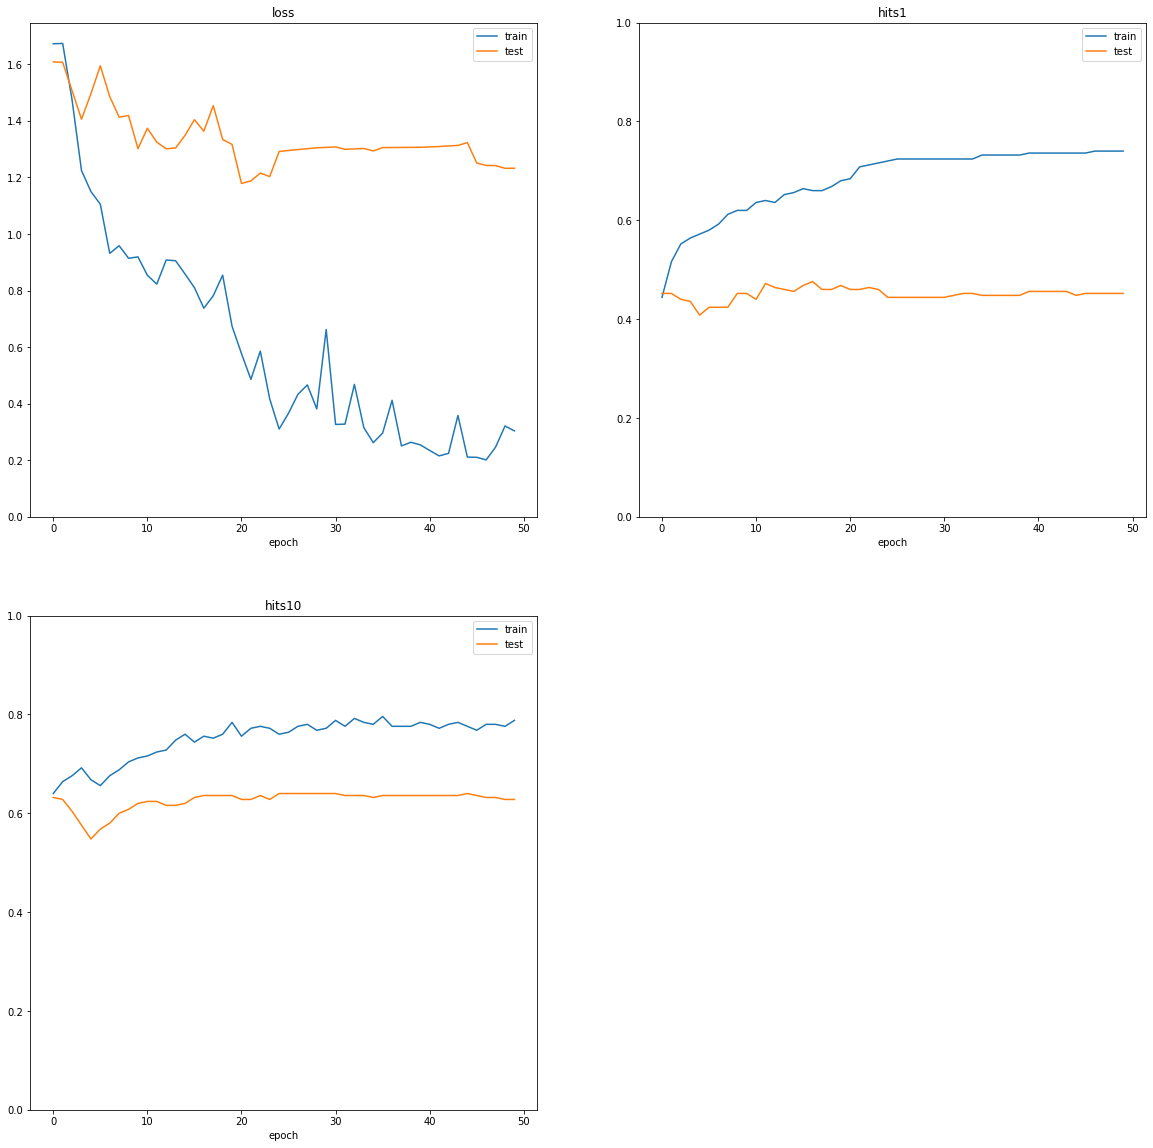

In [18]:
x1, edge_index1, x2, edge_index2, train_y, test_y, perm = \
        get_dataset(dataset, num_nodes, input_dim, num_edges,
                p_erdos_renyi, train_size, be_hyperbolic, c=c, noise=0.05)

model = get_model(be_hyperbolic, input_dim, dim_1, dim_2, num_layers, cat, k, c=c, aggr=aggr, hyp_mlp=hyp_mlp)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history_train, hits1_history_train, hits10_history_train = [], [], []
loss_history_test, hits1_history_test, hits10_history_test = [], [], []

print('Optimize initial feature matching...\n')
model.num_steps = 0
for epoch in range(50):
    print(f'{epoch} ', end='\r')
    if epoch == 25:
        print('\nRefine correspondence matrix...\n')
#         model.psi_2.requires_grad_(False)
        model.num_steps = num_steps
        for g in optimizer.param_groups:
            g['lr'] = lr / 10




    loss, hits1, hits10 = train()

    loss_history_train.append(loss)
    hits1_history_train.append(hits1)
    hits10_history_train.append(hits10)

    loss, hits1, hits10 = test()
    if torch.isnan(loss).item():
        print('NUN LOSS DETECTED')
        break

    loss_history_test.append(loss)
    hits1_history_test.append(hits1)
    hits10_history_test.append(hits10)

plot_results(loss_history_train, hits1_history_train, hits10_history_train,
            loss_history_test, hits1_history_test, hits10_history_test)

Optimize initial feature matching...

HDGMC_erdos_renyi.jpg


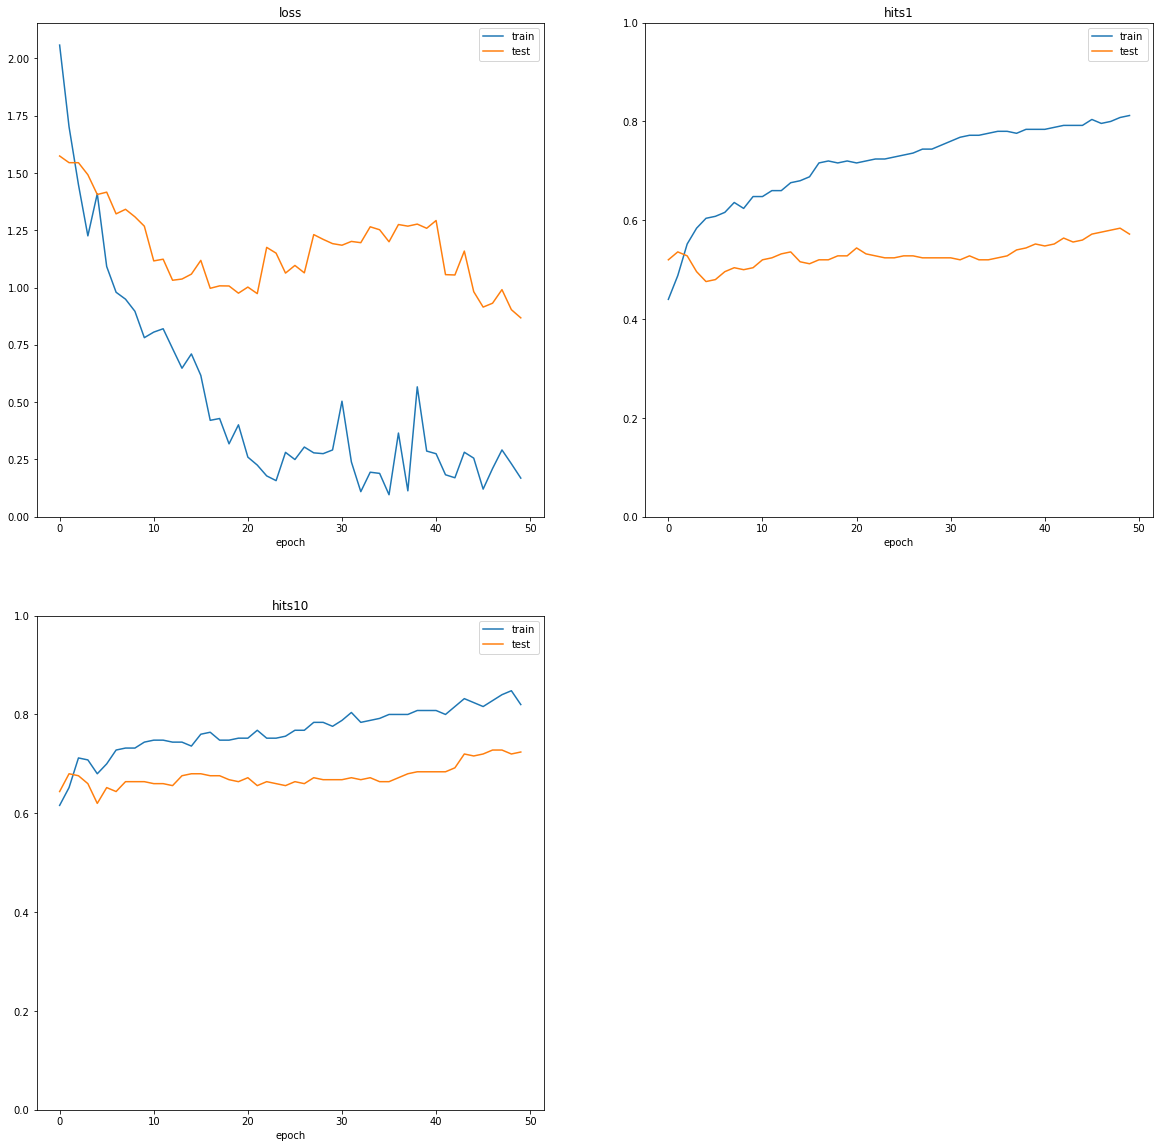

In [19]:
x1, edge_index1, x2, edge_index2, train_y, test_y, perm = \
        get_dataset(dataset, num_nodes, input_dim, num_edges,
                p_erdos_renyi, train_size, be_hyperbolic, c=c, noise=0.05)

model = get_model(be_hyperbolic, input_dim, dim_1, dim_2, num_layers, cat, k, c=c, aggr=aggr, hyp_mlp=hyp_mlp)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history_train, hits1_history_train, hits10_history_train = [], [], []
loss_history_test, hits1_history_test, hits10_history_test = [], [], []

print('Optimize initial feature matching...\n')
model.num_steps = 0
for epoch in range(50):
    print(f'{epoch} ', end='\r')

    loss, hits1, hits10 = train()

    loss_history_train.append(loss)
    hits1_history_train.append(hits1)
    hits10_history_train.append(hits10)

    loss, hits1, hits10 = test()
    if torch.isnan(loss).item():
        print('NUN LOSS DETECTED')
        break

    loss_history_test.append(loss)
    hits1_history_test.append(hits1)
    hits10_history_test.append(hits10)

plot_results(loss_history_train, hits1_history_train, hits10_history_train,
            loss_history_test, hits1_history_test, hits10_history_test)

In [225]:
hyp = Hyperboloid()

In [119]:
a = torch.randn(3)
b = torch.randn(3)

a = hyp.expmap0(a, c=c)
b = hyp.expmap0(b, c=c)


print(hyp.minkowski_dot(b, b).item(), hyp.minkowski_dot(a, a).item())
a = hyp.to_poincare(a, c=c)
b = hyp.to_poincare(b, c=c)
print(a.pow(2).sum(dim=-1), b.pow(2).sum(dim=-1))

hyp.poincare_mobius_add(a, -b, c=c) + hyp.poincare_mobius_add(b, -a, c=c)

-1.0000019073486328 -0.9999961853027344
tensor(0.6941) tensor(0.5399)


tensor([ 0.6384, -0.4430])

In [120]:
S_0, S_L = model(x1, edge_index1, None, None, x2,
                   edge_index2, None, None)

In [121]:
S_0.sort(dim=-1)[0][:, -1]

tensor([0.1099, 0.1198, 0.1083, 0.1528, 0.1571, 0.1332, 0.1223, 0.0834, 0.2108,
        0.9566, 0.1060, 0.4290, 0.1553, 0.7352, 0.5204, 1.0000, 0.1178, 0.2042,
        0.1734, 0.1077, 0.9739, 0.1241, 0.4184, 1.0000, 0.5748, 1.0000, 0.9838,
        1.0000, 0.9459, 0.1395, 1.0000, 0.5298, 0.1800, 0.9993, 1.0000, 0.8923,
        0.8358, 0.9999, 0.9983, 0.8519, 0.9999, 0.3006, 0.5946, 0.6572, 0.1554,
        1.0000, 1.0000, 0.2497, 0.9948, 0.4184, 0.9930, 0.5936, 0.9009, 0.9992,
        1.0000, 0.7259, 1.0000, 0.9998, 0.4189, 0.9815, 0.9759, 0.5382, 0.9909,
        0.9931, 0.7705, 1.0000, 1.0000, 0.4241, 1.0000, 1.0000, 0.8538, 0.6057,
        0.9899, 0.3273, 0.2553, 1.0000, 0.6867, 0.9646, 0.9948, 0.9849, 0.9003,
        0.7333, 0.2532, 0.9938, 0.5016, 0.5431, 1.0000, 0.9108, 0.6585, 0.9558,
        0.2286, 0.9998, 1.0000, 0.1730, 1.0000, 1.0000, 1.0000, 0.2240, 0.1909,
        0.5800], device='cuda:0')

In [122]:
net1 = model.psi_1
net2 = model.psi_2
mlp = model.mlp
hyp = Hyperboloid()
mlp[0].set_verbose(True)

In [123]:
h_s = net1(x1, edge_index1, sizes=None)
h_t = net1(x2, edge_index2, sizes=None)
h_s_len = h_s.shape[0]


h_s, h_t = (h_s.detach(), h_t.detach()) if 1 else (h_s, h_t)





h_s, s_mask = to_dense_batch(h_s, None, fill_value=0)
h_t, t_mask = to_dense_batch(h_t, None, fill_value=0)


assert h_s.size(0) == h_t.size(0), 'Encountered unequal batch-sizes'
(B, N_s, C_out), N_t = h_s.size(), h_t.size(1)

R_in, R_out = net2.in_channels, net2.out_channels


# ------ Dense variant ------ #
S_hat = h_s @ h_t.transpose(-1, -2) - 2 * torch.einsum('bi,bj->bij', (h_s[..., 0], h_t[..., 0]))# [B, N_s, N_t, C_out]
# print(f'Initial mindots:\n{S_hat}')
S_mask = s_mask.view(B, N_s, 1) & t_mask.view(B, 1, N_t)
S_0 = masked_softmax(S_hat, S_mask, dim=-1)[s_mask]
# print(f'S after masked softmax:\n{S_0.sort(dim=-1)[0][:, -1]}')


for _ in range(1):
    S = masked_softmax(S_hat, S_mask, dim=-1)
    r_s = torch.randn((B, N_s, R_in), dtype=h_s.dtype,
                      device=h_s.device) 
    r_t = S.transpose(-1, -2) @ r_s

    r_s = hyp.expmap0(r_s, c=c)
    r_s = hyp.proj(r_s, c=c)

    r_t = hyp.expmap0(r_t, c=c)
    r_t = hyp.proj(r_t, c=c)
    
    print('-----BEFORE PSI_2-----')
    norm_s = hyp.minkowski_dot(r_s, r_s)
    valid_s = ((norm_s > -1.1) & (norm_s < -0.9)).sum()
    valid_s = valid_s.float() / r_s.shape[-2] 

    norm_t = hyp.minkowski_dot(r_t, r_t)
    valid_t = ((norm_t > -1.1) & (norm_t < -0.9)).sum()
    valid_t = valid_t.float() / r_t.shape[-2] 

    print(f'on hyperboloid: {valid_s:.02f}, {valid_t:.02f}')
#     print(f'\ndiff:\n{(r_s-r_t).norm(p=2)}')
    print('+++++BEFORE PSI_2+++++')
    
    r_s, r_t = to_sparse(r_s, s_mask), to_sparse(r_t, t_mask)
    o_s = net2(r_s, edge_index1)
    o_t = net2(r_t, edge_index2)
    o_s, o_t = to_dense(o_s, s_mask), to_dense(o_t, t_mask)
    
    print('-----AFTER PSI_2-----')
    norm_s = hyp.minkowski_dot(o_s, o_s)
    valid_s = ((norm_s > -1.1) & (norm_s < -0.9)).sum()
    valid_s = valid_s.float() / o_s.shape[-2] 

    norm_t = hyp.minkowski_dot(o_t, o_t)
    valid_t = ((norm_t > -1.1) & (norm_t < -0.9)).sum()
    valid_t = valid_t.float() / o_t.shape[-2] 
    
#     print(f'norm is: {norm_t}')
    print(f'on hyperboloid: {valid_s:.02f}, {valid_t:.02f}')
#     print(f'\ndiff:\n{(o_s-o_t)}')
    print('+++++AFTER PSI_2+++++')

    o_s, o_t = hyp.to_poincare(o_s, c=c), \
                                hyp.to_poincare(o_t, c=c)
    D = hyp.poincare_mobius_coadd(o_s.view(B, N_s, 1, R_out-1),
                                             -o_t.view(B, 1, N_t, R_out-1), c=c)
                    
    D = hyp.to_hyperboloid(D, c=c)
                
    print(f'\nD:\n{D}')
    S_hat = S_hat + mlp(D).squeeze(-1).masked_fill(~S_mask, 0)
    
    print(f'D:\n{mlp(D).squeeze(-1).masked_fill(~S_mask, 0)}')


    S_L = masked_softmax(S_hat, S_mask, dim=-1)[s_mask]

-----BEFORE PSI_2-----
on hyperboloid: 1.00, 1.00
+++++BEFORE PSI_2+++++
-----AFTER PSI_2-----
on hyperboloid: 0.95, 0.94
+++++AFTER PSI_2+++++

D:
tensor([[[[-1.0024e+00,  3.7036e-03, -1.9610e-02,  ...,  4.5169e-02,
           -3.6263e-02,  1.3689e-03],
          [-1.0947e+00, -1.6431e-01,  6.6979e-02,  ..., -8.4661e-03,
           -1.5758e-01, -3.3835e-01],
          [-1.0509e+00, -1.4848e-01,  1.2654e-02,  ..., -4.4248e-02,
           -2.6533e-01, -8.0328e-02],
          ...,
          [-1.0024e+00, -4.0468e-02, -7.5888e-03,  ...,  2.2394e-03,
           -2.4529e-02, -3.2520e-02],
          [-1.2787e+00, -2.5798e-01,  1.7811e-01,  ..., -1.9753e-01,
           -1.6879e-01, -6.2333e-01],
          [-1.0013e+00, -1.4235e-02, -2.8296e-03,  ...,  5.6897e-03,
           -2.7877e-02, -3.7461e-02]],

         [[-1.0000e+00,  1.0876e-03,  2.7352e-04,  ...,  1.6675e-03,
           -5.2792e-05,  3.0926e-03],
          [-1.2673e+00, -2.4807e-01,  4.1751e-01,  ...,  4.6994e-02,
           -2.083

In [134]:
hyp.expmap0(torch.tensor([100.]), c=1)

tensor([1.])

In [83]:
mlp

Sequential(
  (0): HypLinear(in_features=10, out_features=1, c=1)
)

In [71]:
o_s

tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan

In [37]:
a = torch.tensor([[1, 2, 3], [4, 5, 6]]).float()
b = torch.tensor([[1, 1, 1],[1, 1, 0]]).float()

In [38]:
hyp.mobius_add(a.view(2, 1, 3), -b.view(1, 2, 3), c=c)

tensor([[[3.7412, 1.9997, 2.9997],
         [3.7414, 1.9995, 3.0000]],

        [[7.8721, 4.9987, 5.9985],
         [7.8728, 4.9989, 5.9993]]])

In [71]:
S_0.argmax(dim=-1)

tensor([3, 3, 3, 7, 3, 3, 3, 9, 3, 3, 3, 3, 3, 0, 3], device='cuda:0')

In [74]:
mindots = h_s @ h_t.transpose(-1, -2) - 2 * torch.einsum('bi,bj->bij', (h_s[..., : , 0], h_t[..., : , 0]))

In [76]:
a1 = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
a2 = torch.tensor([[4, 5, 6], [1, 2, 3], [7, 8, 9]])

### TOY LAYER

In [119]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.modules.module import Module

from torch_scatter import gather_csr, scatter, segment_csr
from torch_geometric.nn import MessagePassing

class ToyLayer(MessagePassing):
    def __init__(self, manifold, in_channels, out_channels, c, dropout=0, use_att=False, use_bias=False, verbose=False, deep_verbose=False):
        super().__init__(aggr='add')
        print(f'in: {in_channels}, out: {out_channels}, c: {c}, dropout: {dropout}, att: {use_att}, bias: {use_bias}')
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels))
        self.bias = nn.Parameter(torch.Tensor(out_channels)) if use_bias else None
        self.att = nn.Linear(2 * out_channels, 1) if use_att else None
        self.dropout = nn.Dropout(p=dropout)
        self.manifold = manifold
        self.c = c
        self.verbose = verbose
        self.deep_verbose = deep_verbose
        self.reset_parameters()
    
    def set_verbose(self, verbose):
        self.verbose = verbose
        
    def reset_parameters(self):
        init.eye_(self.weight)
        if self.bias is not None:
            init.constant_(self.bias, 0)
    
    def message(self, x_j, x_i):
        if self.verbose:
                print('--------------------MESSAGE--------------------------')
                print(f'x_j:\n{x_j}')
                print(f'x_i:\n{x_i}')

        out = self.manifold.logmap(x_j, x_i, self.c, self.deep_verbose)
        if self.verbose:
                print(f'out:\n{out}')
                print('++++++++++++++++++++MESSAGE++++++++++++++++++++++++++')
        
        return out
    
    def aggregate(self, inputs, x_i, x_j, index, ptr=None, dim_size=None):
        if ptr is not None:
            print('wasaddssssssssssssssss')
            ptr = expand_left(ptr, dim=self.node_dim, dims=inputs.dim())
            return segment_csr(inputs, ptr, reduce=self.aggr)
        else:
            if self.verbose:
                print('--------------------AGGREGATE--------------------------')
                print(f'inputs:\n{inputs}')
#                 print(f'x_i:\n{x_i}')
#                 print(f'x_j:\n{x_j}')
            if self.att is not None:
                x_i0 = self.manifold.logmap0(x_i, c=self.c)
                x_j0 = self.manifold.logmap0(x_j, c=self.c)
                att_scores = self.att(torch.cat([x_i0, x_j0], dim=-1))
                att_scores = torch.sigmoid(att_scores).reshape(-1, 1)
                out = inputs * att_scores
            else:
                out = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size,
                           reduce=self.aggr)
            if self.verbose:
                print(f'out:\n{out}')
                print('++++++++++++++++++++AGGREGATE++++++++++++++++++++++++++')
                
            return out
        
    def update(self, inputs, x):
        if self.verbose:
            print('----------------------UPDATE-------------------------')
            print(f'inputs:\n{inputs}')
            print(f'x:\n{x}')

        out = self.manifold.expmap(inputs, x, self.c, self.deep_verbose)
        if self.verbose:
            print(f'after expmap:\n{out}')
        out = self.manifold.to_poincare(out, self.c, self.deep_verbose)
        if self.verbose:
            print(f'after to poincare:\n{out}')
        out = F.relu(out)
        if self.verbose:
            print(f'after relu:\n{out}')
        out = self.manifold.to_hyperboloid(out, self.c, self.deep_verbose)
        if self.verbose:
            print(f'out:\n{out}')
            print('++++++++++++++++++++++UPDATE++++++++++++++++++++++++++')
                        
        return out
        
    def forward(self, x, edge_index):
        drop_weight = self.dropout(self.weight)
        x = self.manifold.mobius_matvec(drop_weight, x, self.c, self.deep_verbose)
        if self.bias is not None:
            hyp_bias = self.manifold.expmap0(self.bias.view(1, -1), self.c)
            x = self.manifold.mobius_add(x, hyp_bias, self.c)
        if self.verbose:
            print('----------------------LESSGO-------------------------')
            print(f'x:\n{x}')
        
        out = self.propagate(edge_index, x=x)
        
        if self.verbose:
            print(f'out:\n{out}')
            print('++++++++++++++++++++++LESSGO++++++++++++++++++++++++++')
        return out

### TOY DATA

In [129]:
num_nodes = 4
input_dim = 3

ind = np.arange(num_nodes)

x = torch.randn(num_nodes, input_dim)


hyp = Hyperboloid()

x = hyp.proj_tan0(x, c=1)
x = hyp.expmap0(x, c=1)
x = hyp.proj(x, c=1)

edge_index = torch.tensor([[1, 2, 3, 0, 1, 2, 3], [1, 2, 3, 0, 0, 0, 0]]).long()

In [130]:
toy = ToyLayer(hyp, 3, 3, 1, verbose=True)

in: 3, out: 3, c: 1, dropout: 0, att: False, bias: False


In [131]:
toy(x, edge_index)

----------------------LESSGO-------------------------
x:
tensor([[ 1.0171, -0.0096, -0.1857],
        [ 1.3143,  0.7814,  0.3416],
        [ 2.6070,  2.0708, -1.2281],
        [ 1.9311,  0.6741,  1.5081]], grad_fn=<AddBackward0>)
--------------------MESSAGE--------------------------
x_j:
tensor([[ 1.3143,  0.7814,  0.3416],
        [ 2.6070,  2.0708, -1.2281],
        [ 1.9311,  0.6741,  1.5081],
        [ 1.0171, -0.0096, -0.1857],
        [ 1.3143,  0.7814,  0.3416],
        [ 2.6070,  2.0708, -1.2281],
        [ 1.9311,  0.6741,  1.5081]], grad_fn=<IndexSelectBackward>)
x_i:
tensor([[ 1.3143,  0.7814,  0.3416],
        [ 2.6070,  2.0708, -1.2281],
        [ 1.9311,  0.6741,  1.5081],
        [ 1.0171, -0.0096, -0.1857],
        [ 1.0171, -0.0096, -0.1857],
        [ 1.0171, -0.0096, -0.1857],
        [ 1.0171, -0.0096, -0.1857]], grad_fn=<IndexSelectBackward>)
out:
tensor([[-1.2140e-07, -1.8407e-07, -4.6017e-08],
        [-9.0693e-06, -8.3300e-06,  5.2063e-06],
        [-3.1964e-07,

tensor([[1.0000, 0.0000, 0.0000],
        [1.3143, 0.7814, 0.3416],
        [1.9833, 1.7127, 0.0000],
        [1.9311, 0.6741, 1.5081]], grad_fn=<DivBackward0>)